In [2]:
import mne 
import numpy as np
import os

In [32]:
# List of BDF file paths in order
raw_files = [
    r'C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block01.bdf',
    r'C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block02.bdf',
    r'C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block03.bdf',
    r'C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block04.bdf'
]

# Load all blocks
raw_list = [mne.io.read_raw_bdf(f, preload=True) for f in raw_files]

# Concatenate them into single raw object
raw = mne.concatenate_raws(raw_list)

# Inspect metadata
print(raw.info)

Extracting EDF parameters from C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block01.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 440319  =      0.000 ...   859.998 secs...
Extracting EDF parameters from C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block02.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 277503  =      0.000 ...   541.998 secs...
Extracting EDF parameters from C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block03.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 434687  =      0.000 ...   848.998 secs...
Extracting EDF parameters from C:\Users\NARONG\Downloads\raw-20251110T054032Z-1-001\raw\Pilot04\EEG\2025-10-20-pilot04-block04.bdf...
BDF file detected
Setting channel info struc

In [33]:
raw.set_channel_types({
    'EXG1': 'eeg',
    'EXG2': 'eeg',
    'EXG3': 'eog',
    'EXG4': 'eog',
    'EXG5': 'eog',
    'EXG6': 'eog',
    'EXG7': 'ecg',
    'EXG8': 'ecg',
})

Measurement date,"October 20, 2025 16:31:58 GMT"
Experimenter,Unknown
Participant,
Digitized points,Not available
Good channels,"66 EEG, 4 EOG, 2 ECG, 1 Stimulus"
Bad channels,None
EOG channels,"EXG3, EXG4, EXG5, EXG6"
ECG channels,"EXG7, EXG8"
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,104.00 Hz


In [34]:
montage = mne.channels.make_standard_montage('biosemi64')  # for Biosemi
raw.set_montage(montage, on_missing='ignore')

Measurement date,"October 20, 2025 16:31:58 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"66 EEG, 4 EOG, 2 ECG, 1 Stimulus"
Bad channels,None
EOG channels,"EXG3, EXG4, EXG5, EXG6"
ECG channels,"EXG7, EXG8"
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,104.00 Hz


In [35]:
filt_raw = raw.set_eeg_reference(ref_channels=["EXG1", "EXG2"])

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


In [36]:
filt_raw.filter(l_freq=1., h_freq=40.)

Filtering raw data in 4 contiguous segments
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Measurement date,"October 20, 2025 16:31:58 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"66 EEG, 4 EOG, 2 ECG, 1 Stimulus"
Bad channels,None
EOG channels,"EXG3, EXG4, EXG5, EXG6"
ECG channels,"EXG7, EXG8"
Sampling frequency,512.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [37]:
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs
ica = ICA(n_components=20,method='picard', max_iter="auto", random_state=97)
filt_raw.drop_channels(["EXG1", "EXG2"])
ica.fit(filt_raw)


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 167.6s.


Method,picard
Fit parameters,max_iter=500
Fit,156 iterations on raw data (1589760 samples)
ICA components,20
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


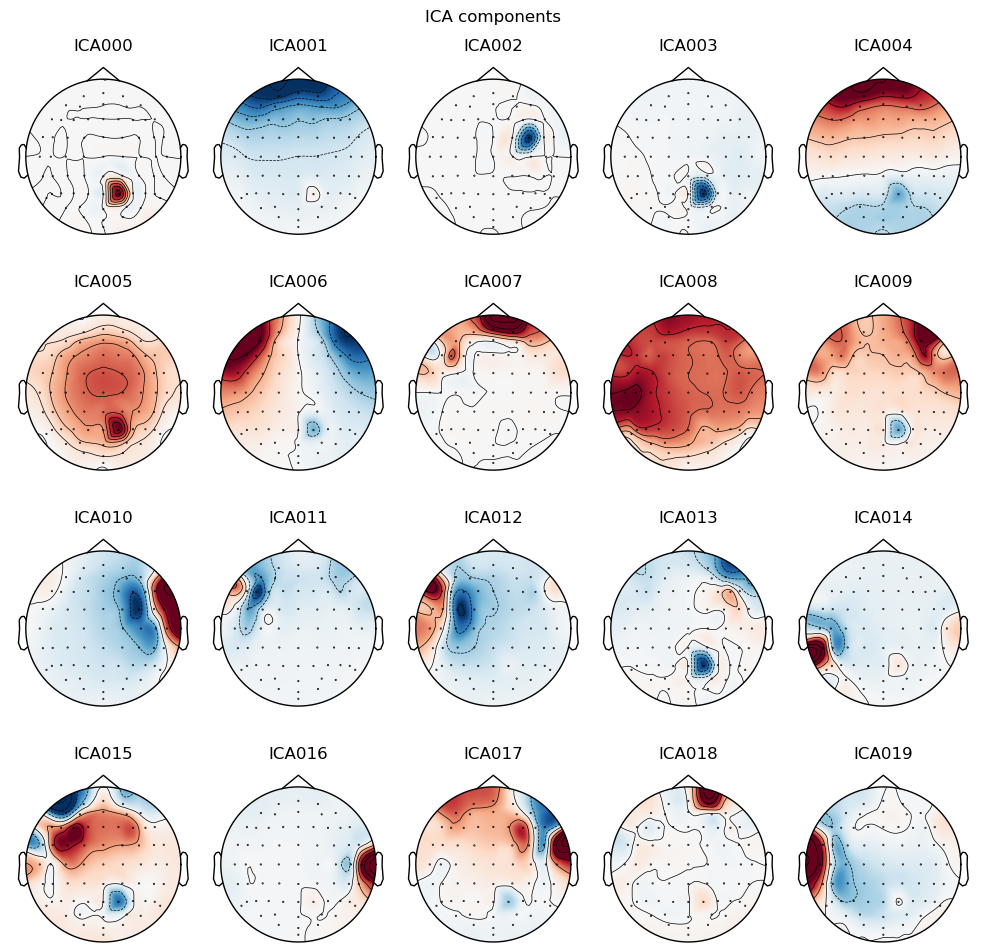

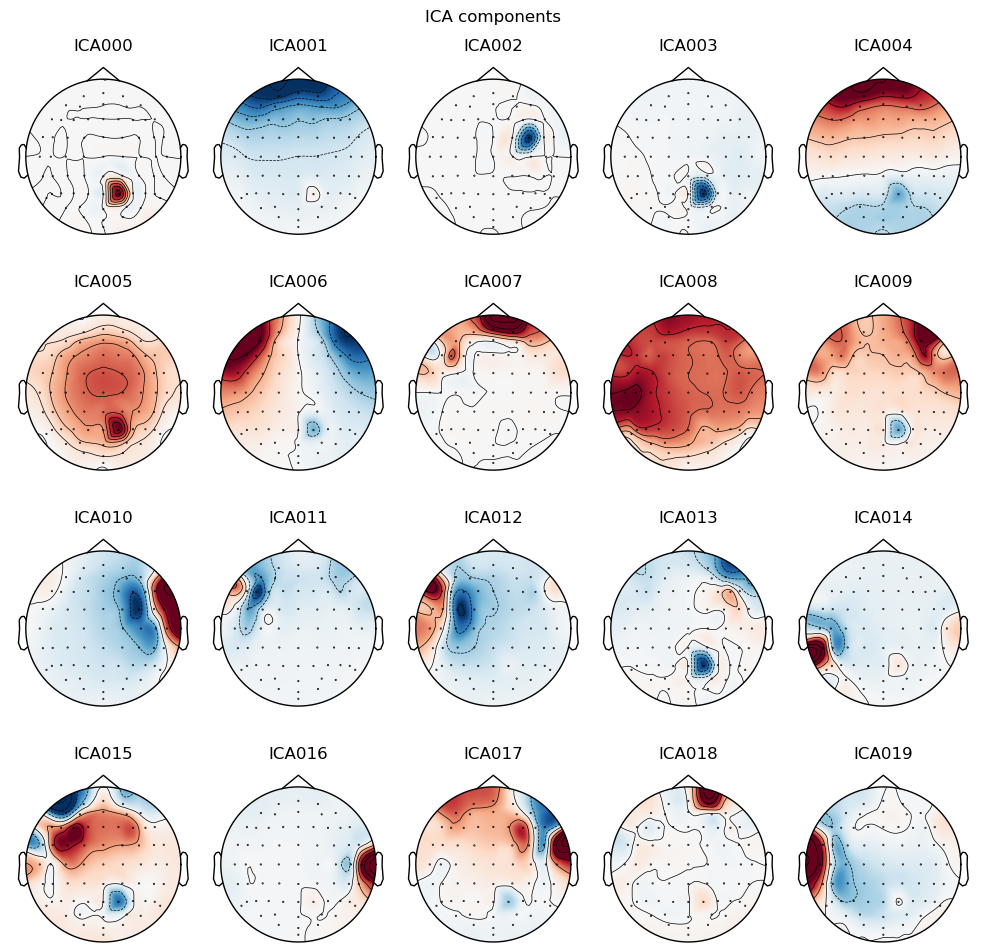

In [171]:
ica.plot_components()

In [38]:
ica.exclude = [0, 1, 2, 3] 

In [39]:
# folder = os.path.dirname(raw_data_path)
# basename = os.path.splitext(os.path.basename(raw_data_path))[0]

# ica_path = os.path.join(folder, f'{basename}-ica.fif')
# ica.save(ica_path, overwrite=True)
ica.apply(filt_raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 64 PCA components


Measurement date,"October 20, 2025 16:31:58 GMT"
Experimenter,Unknown
Participant,
Digitized points,67 points
Good channels,"64 EEG, 4 EOG, 2 ECG, 1 Stimulus"
Bad channels,None
EOG channels,"EXG3, EXG4, EXG5, EXG6"
ECG channels,"EXG7, EXG8"
Sampling frequency,512.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [40]:
events = mne.find_events(filt_raw)
events

Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
3674 events found on stim channel Status
Event IDs: [    1     2     3     4     5     6     7     8     9    10    11    12
    13    14    15    16    17    18    19    20    71    72    73    74
    87    88    89    90    91    92    93    94    95   103   104   105
   106   107   110   111 65536]


array([[  50067,       0,      74],
       [  50070,      74,     111],
       [  50302,       0,       4],
       ...,
       [1145326,       0,      11],
       [1145898,       0,      90],
       [1152512,       0,   65536]], dtype=int64)

In [41]:
sfreq = raw.info['sfreq']
prim_codes = [71, 72, 73, 74]
face_codes = list(range(1, 21))

for code in prim_codes:
    prim_samples = events[events[:, 2] == code, 0]
    print(f"\nCode {code}:")
    for s in prim_samples[:5]:  # just look at first 5 trials per condition
        # find nearest face event (any 1–20)
        diffs = events[np.isin(events[:, 2], face_codes), 0] - s
        nearest_idx = np.argmin(np.abs(diffs))
        delay_ms = diffs[nearest_idx] / sfreq * 1000
        print(f"  nearest face = {events[np.isin(events[:, 2], face_codes)][nearest_idx, 2]}, delay = {delay_ms:.1f} ms")

new_trigger_offset = 100  # 71->171, 72->172, etc.
new_events = []

for prim_code in [71, 72, 73, 74]:
    prim_samples = events[events[:,2] == prim_code, 0]
    face_samples = events[np.isin(events[:,2], range(1,21)), 0]
    face_codes = events[np.isin(events[:,2], range(1,21)), 2]

    for s in prim_samples:
        # compute delays to all face triggers
        diffs = (face_samples - s).astype(float)  # <- convert to float
        diffs[diffs < 0] = np.inf  # ignore faces before the prime
        if np.all(diffs == np.inf):
            continue  # no future face found
        nearest_idx = np.argmin(diffs)
        face_sample = face_samples[nearest_idx]
        new_code = prim_code + new_trigger_offset
        new_events.append([face_sample, 0, new_code])

new_events = np.array(new_events, dtype=int)



Code 71:
  nearest face = 17, delay = 437.5 ms
  nearest face = 19, delay = 513.7 ms
  nearest face = 19, delay = 535.2 ms
  nearest face = 13, delay = 523.4 ms
  nearest face = 5, delay = 419.9 ms

Code 72:
  nearest face = 9, delay = 478.5 ms
  nearest face = 7, delay = 416.0 ms
  nearest face = 1, delay = 380.9 ms
  nearest face = 15, delay = 535.2 ms
  nearest face = 9, delay = 498.0 ms

Code 73:
  nearest face = 4, delay = 505.9 ms
  nearest face = 12, delay = 441.4 ms
  nearest face = 18, delay = 472.7 ms
  nearest face = 4, delay = 447.3 ms
  nearest face = 4, delay = 486.3 ms

Code 74:
  nearest face = 4, delay = 459.0 ms
  nearest face = 4, delay = 509.8 ms
  nearest face = 12, delay = 527.3 ms
  nearest face = 2, delay = 502.0 ms
  nearest face = 20, delay = 513.7 ms


In [42]:
combined_events = np.vstack([events, new_events])

# Sort chronologically
combined_events = combined_events[np.argsort(combined_events[:, 0])]

In [43]:
event_id = {
    'M-cong': 171,
    'M-incong': 172,
    'F-cong': 173,
    'F-incong': 174
}

epochs = mne.Epochs(
    raw,
    combined_events,
    event_id=event_id,
    tmin=-0.2,
    tmax=1.0,
    baseline=(-0.2, 0),
    event_repeated='drop',
    preload=True
)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1019 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1019 events and 615 original time points ...
0 bad epochs dropped


In [ ]:
epochs['M-cong'].plot(picks=['Fz','AFz','Fpz'])

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [178]:
congruent = mne.combine_evoked(
    [epochs['M-cong'].average(), epochs['F-cong'].average()],
    weights='equal'
)

incongruent = mne.combine_evoked(
    [epochs['M-incong'].average(), epochs['F-incong'].average()],
    weights='equal'
)

In [179]:
channels_of_interest = ['Oz', 'POz', 'Pz', 'CPz', 'Cz', 'FCz', 'Fz', 'AFz', 'Fpz']


In [180]:
evokeds_dict = {
    'congruent': congruent,
    'incongruent': incongruent
}

C:\Users\NARONG\AppData\Local\Temp\ipykernel_11076\1982883836.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


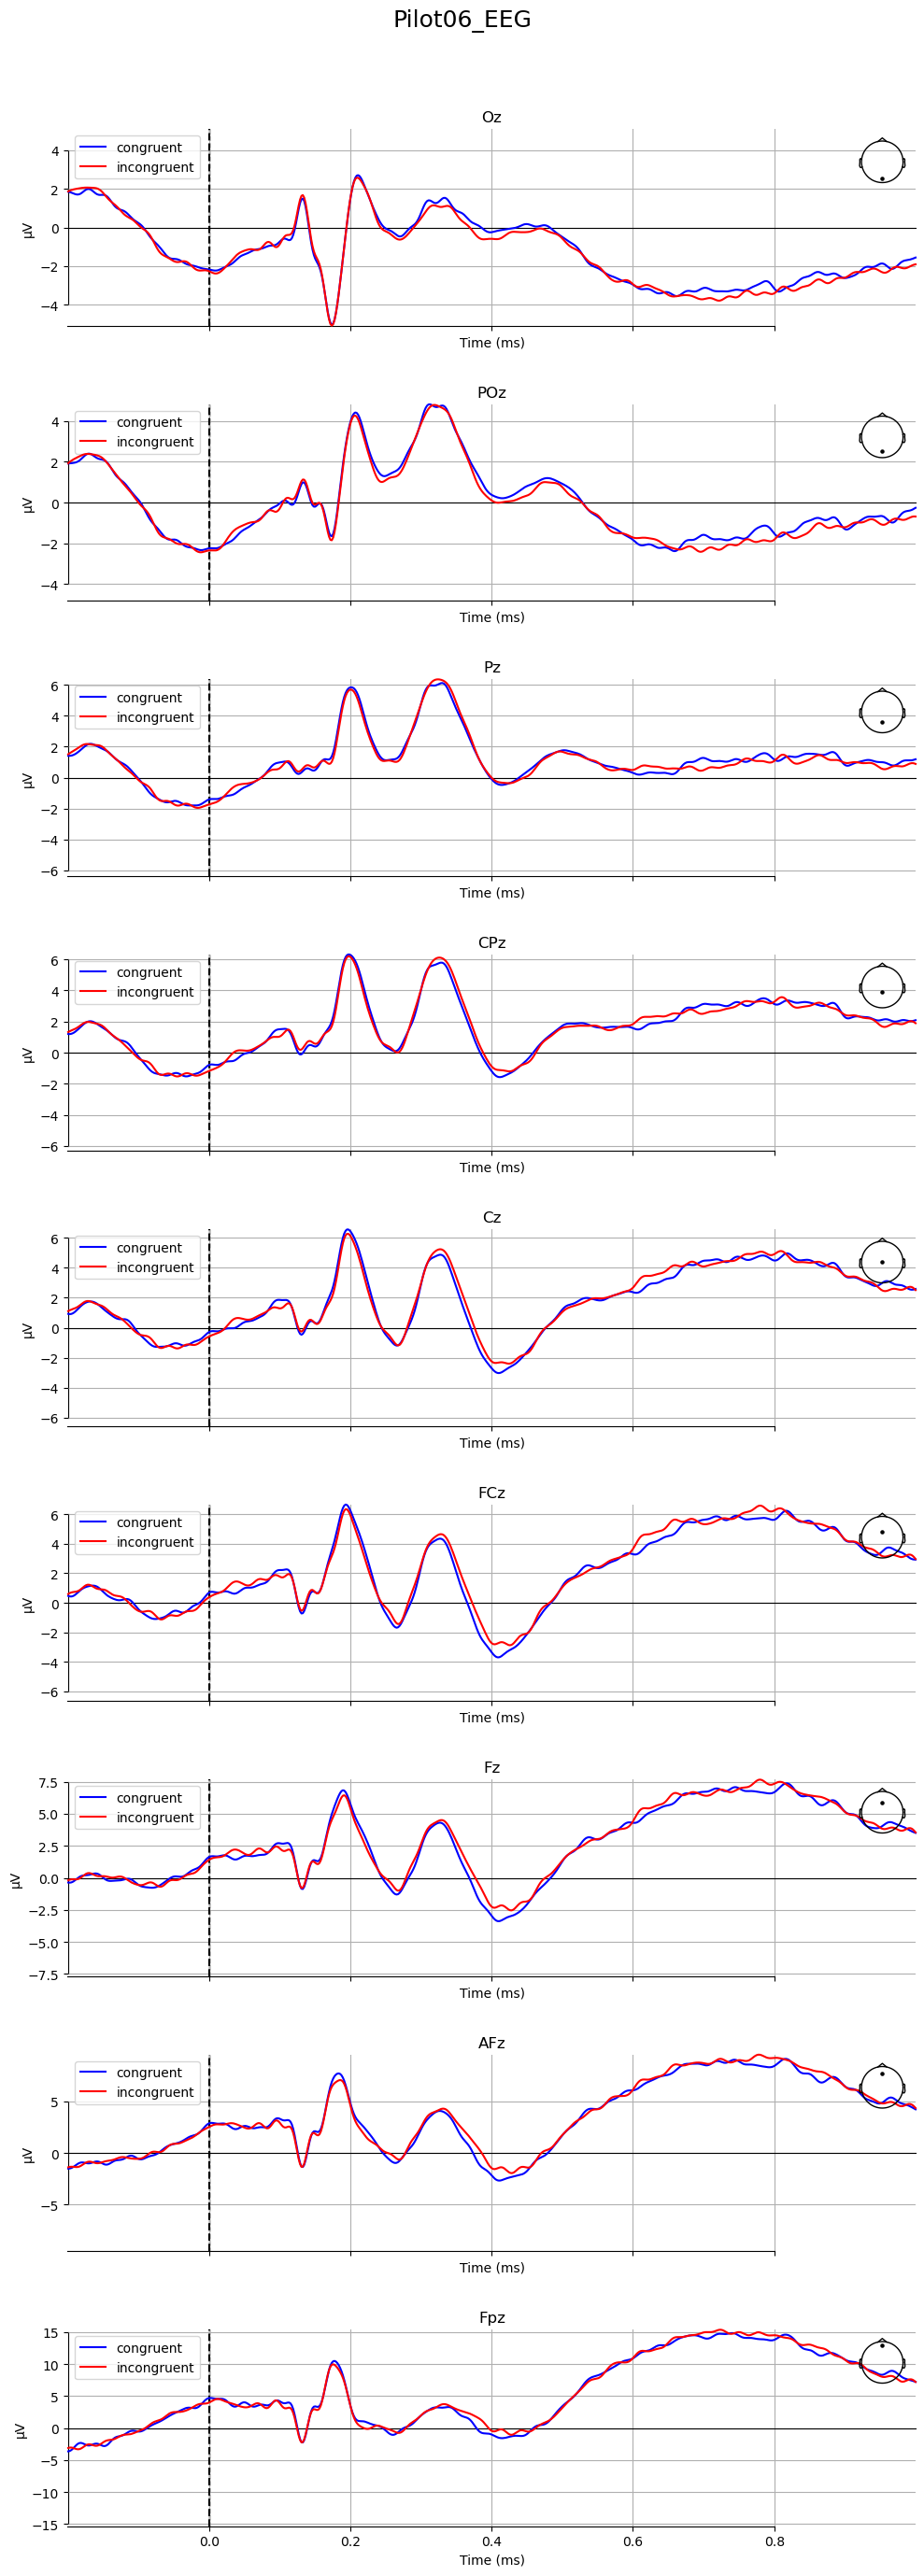

In [182]:
import matplotlib.pyplot as plt

n_channels = len(channels_of_interest)
fig, axes = plt.subplots(n_channels, 1, figsize=(10, 3*n_channels), sharex=True)

for i, ch in enumerate(channels_of_interest):
    mne.viz.plot_compare_evokeds(
        evokeds_dict,
        picks=[ch],
        axes=axes[i],
        colors={'congruent': 'blue', 'incongruent': 'red'},
        show=False
    )
    axes[i].set_title(ch)
    axes[i].set_xlim(incongruent.times[0], congruent.times[-1])
    axes[i].grid(True)

for ax in axes:
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlabel('Time (ms)')

fig.suptitle('Pilot06_EEG', fontsize=18, y=1.02)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()
